# Outlier detection with Autoecoders

Purpose: We would like to detect outlier talks in the Danish Parliament, to see whether we can detect unusual events. 

In general, there are different ways to calculate differences between documents. In our case, we are calculating the difference between the actual document, and the generated (trough a decoder) document vector. 

1. Using vector space model and computing cosine similarity. (Doesn't use embeddings) - **This is the one we are currently using**. 
2. Using tf-idf with cosine similarity. (Doesn't use embeddings)
3. Averaging word embeddings over the sentence to get document vector and calculating cosine similarity. (Uses word embeddings) - **could maybe be better**. 

A bit about cosine similarity: The cosine similarity measures  and captures the angle of the word vectors and not the magnitude, the total similarity of 1 is at a 0-degree angle while no similarity is expressed as a 90-degree angle. (source: https://www.researchgate.net/post/What_is_the_best_way_to_measure_text_similarities_based_on_word2vec_word_embeddings) 

##### Table of content:
1. [Read packages and data](#part1)
2. [Preprocessing](#part2)
3. [Text processing](#part3)
4. [Counting the most frequent words](#part4)
5. [title](#part5)


## <font color='blue'>Part 1</font>: Read packages and data
<a id=part1></a>

#### packages

#### data

In [1]:
import pandas as pd
from nltk.stem import SnowballStemmer
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import nltk
from gensim import utils
import gensim.parsing.preprocessing as gsp
from nltk.tokenize import word_tokenize
import pickle
from sklearn.neural_network import MLPRegressor
from sklearn.externals import joblib
from scipy.spatial.distance import cosine
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


### Mount drive

In [0]:
#mount
def mount():
  from google.colab import drive
  drive.mount('/content/gdrive')

In [3]:
mount()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
#reading the data and resetting index
df = pd.read_csv('/content/drive/My Drive/Uni/MMC/4. semester/CDA/data/DPC_speeches.csv')
df = df.reset_index().iloc[:,2:]

In [0]:
df.head()

,Tale,Starttid,Sluttid,Navn,Rolle,Tekst
0,None,2011-09-30T13:00:16.860,2011-09-30T13:00:28.140,None,midlertidig formand,Mødet er åbnet.
1,None,2011-09-30T13:55:01.640,2011-09-30T13:55:12.063,None,midlertidig formand,Så er mødet genoptaget.
2,None,2011-09-30T13:59:37.437,2011-09-30T13:59:56.640,None,formand,Der er ikke mere at foretage i dette møde.Folk...
3,None,2011-09-30T13:00:28.140,2011-09-30T13:00:52.110,None,midlertidig formand,Forhandlingen er åbnet. Fru Karen Klint.
4,None,2011-09-30T13:00:52.110,2011-09-30T13:05:42.060,Karen J. Klint,medlem,Tak for det. Det er jo dejligt at se så fyldt ...


In [0]:
#reading list of FT members
ft_mem = pd.read_csv('/content/drive/My Drive/Uni/MMC/4. semester/CDA/data/fm.csv')

## <font color='blue'>Part 2</font>: Preprocessing
<a id=part2></a>

### Adding parties to the politicians

In [0]:
#checking how many unique names in our dataset
xml = list(df.Navn.unique())
len(xml)

318

In [0]:
#Checking how many names in the ft dataset
ft = list(ft_mem.Spørger.unique())
ft = [x[0:-1] for x in ft] #removing whitespace in the end of every name
len(ft)

437

In [0]:
#making a list of the set values
set_ = list(set(xml) & set(ft))

In [0]:
#removing whitespace in the end of every name
ft_mem['Spørger'] = ft_mem['Spørger'].apply(lambda x: x[0:-1])

In [0]:
#filtering out the names that we are looking for which are matching in the list of FT members
match = ft_mem[ft_mem['Spørger'].isin(set_)]

In [0]:
#checking if the names are unique
print(len(match))
match.Spørger.nunique()

279


261

In [0]:
#the names are not unique, to we keep the last duplicate name (assume that that is the latest party)
match = match.drop_duplicates(subset='Spørger', keep="last")

In [0]:
df.shape

(236966, 6)

In [0]:
#merging the two dataframes
df_m = df.merge(match, left_on = "Navn", right_on = "Spørger", how='left')

In [0]:
df_m.shape

(236966, 10)

In [0]:
#looking only at specific columns
df_m = df_m[['Starttid', 'Sluttid', 'Navn', 'Rolle', 'Tekst', 'Parti']]

### Only looking at names which are not none. Furthermore, removing the 'formand'

In [0]:
#only looking at relevant names
df_m = df_m[df_m.Navn!='None']

In [0]:
#removing all the speeches from the 'formand' 
df_m = df_m[~df_m.Rolle.isin(['formand'])]
df_m = df_m.reset_index().iloc[:,1:]

In [0]:
df_m.head()

,Starttid,Sluttid,Navn,Rolle,Tekst,Parti
0,2011-09-30T13:00:52.110,2011-09-30T13:05:42.060,Karen J. Klint,medlem,Tak for det. Det er jo dejligt at se så fyldt ...,S
1,2011-09-30T13:05:42.060,2011-09-30T13:06:52.970,Karen J. Klint,medlem,Vedrørende valget i Grønland indstiller et eni...,S
2,2011-03-02T13:01:23.263,2011-03-02T13:03:10.263,John Dyrby Paulsen,medlem,Tak for det. Jeg står her med en rapport fra F...,S
3,2011-03-02T13:03:11.407,2011-03-02T13:04:19.743,Gitte Lillelund Bech,minister,Jeg takker for spørgsmålet. Hr. John Dyrby Pau...,V
4,2011-03-02T13:04:20.913,2011-03-02T13:05:18.180,John Dyrby Paulsen,medlem,Tak for svaret. Det er jeg jo enig med ministe...,S


### Timestamps

In [0]:
#making dates into datetime
df_m.Starttid = pd.to_datetime(df_m.Starttid)
df_m.Sluttid = pd.to_datetime(df_m.Sluttid)

In [0]:
#creating a date columns
df_m['Dato'] = df_m.Starttid.dt.date

#and keeping start and endtime to a time variable
df_m['Starttid'] = df_m['Starttid'].dt.time
df_m['Sluttid'] = df_m['Sluttid'].dt.time

In [0]:
df_m.head()

,Starttid,Sluttid,Navn,Rolle,Tekst,Parti,Dato
0,13:00:52.110000,13:05:42.060000,Karen J. Klint,medlem,Tak for det. Det er jo dejligt at se så fyldt ...,S,2011-09-30
1,13:05:42.060000,13:06:52.970000,Karen J. Klint,medlem,Vedrørende valget i Grønland indstiller et eni...,S,2011-09-30
2,13:01:23.263000,13:03:10.263000,John Dyrby Paulsen,medlem,Tak for det. Jeg står her med en rapport fra F...,S,2011-03-02
3,13:03:11.407000,13:04:19.743000,Gitte Lillelund Bech,minister,Jeg takker for spørgsmålet. Hr. John Dyrby Pau...,V,2011-03-02
4,13:04:20.913000,13:05:18.180000,John Dyrby Paulsen,medlem,Tak for svaret. Det er jeg jo enig med ministe...,S,2011-03-02


## <font color='blue'>Part 3</font>: Text processing
<a id=part3></a>

### Cleaning text with gensim package

In [0]:
#creating different filters
filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric
          ]

In [0]:
def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

In [0]:
#apply clean-text function to all the text
df_m['Tekst_clean'] = df_m['Tekst'].apply(lambda x: clean_text(x))

### Tokenizing text

In [0]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
#using tokenize package to tokenize all `Tekst`
df_m['T_Tekst'] = df_m['Tekst_clean'].apply(lambda x: word_tokenize(x))

### Removing stopwords

In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
#defining the danish stopwords from NLTK
dk_sw = nltk.corpus.stopwords.words('danish')

In [0]:
#adding stopwords (manual filter)
more_stopwords = ['ministeren',
'værsgo',
'så',
'tak',
'ja',
'svare',
'ordføreren',
'svar',
'spørgsmålet',
'svarer', 'spørgsmål', 'ordfører','hr','fru']

In [0]:
#appending manual stopwords to the nltk list
for word in more_stopwords:
    dk_sw.append(word)

In [0]:
#Making a column to contain all the clean text without stopwords
df_m['T_Tekst_stopw'] = df_m['T_Tekst'].apply(lambda x: [word for word in x if not word in dk_sw])

### Stemming words

In [0]:
#choosing the stemmer
stemmer = SnowballStemmer("danish")

In [0]:
#testing 
stemmer.stem("købte")

'købt'

In [0]:
#stemming all words
df_m['T_Tekst_stopw_stem'] = df_m['T_Tekst_stopw'].apply(lambda x: [stemmer.stem(item) for item in x])

### Removing stemmed stopwords (extra)

This is an iterative process which as a result of the clusteirng... (not as relevant here in the Autoencoder)

In [0]:
#extra stopwords
esw = ['kan', 'kom', 'sig', 'gør','få','–','«','»','men','altså']

#putting everything into the clean columns (T_Tekst_stopw_stem)
df_m['T_Tekst_stopw_stem'] = df_m['T_Tekst_stopw_stem'].apply(lambda x: [word for word in x if not word in esw])

In [0]:
df_m.head()

,Starttid,Sluttid,Navn,Rolle,Tekst,Parti,Dato,Tekst_clean,T_Tekst,T_Tekst_stopw,T_Tekst_stopw_stem
0,13:00:52.110000,13:05:42.060000,Karen J. Klint,medlem,Tak for det. Det er jo dejligt at se så fyldt ...,S,2011-09-30,tak for det det er jo dejligt at se så fyldt e...,"[tak, for, det, det, er, jo, dejligt, at, se, ...","[dejligt, se, fyldt, sal, publikumsbænkene, hø...","[dej, se, fyld, sal, publikumsbænk, højtid, da..."
1,13:05:42.060000,13:06:52.970000,Karen J. Klint,medlem,Vedrørende valget i Grønland indstiller et eni...,S,2011-09-30,vedrørende valget i grønland indstiller et eni...,"[vedrørende, valget, i, grønland, indstiller, ...","[vedrørende, valget, grønland, indstiller, eni...","[vedrør, valg, grønland, indstil, enig, udvalg..."
2,13:01:23.263000,13:03:10.263000,John Dyrby Paulsen,medlem,Tak for det. Jeg står her med en rapport fra F...,S,2011-03-02,tak for det jeg står her med en rapport fra fo...,"[tak, for, det, jeg, står, her, med, en, rappo...","[står, rapport, forsvarets, færdselssikkerheds...","[står, rapport, forsvar, færdselssikkerhedskom..."
3,13:03:11.407000,13:04:19.743000,Gitte Lillelund Bech,minister,Jeg takker for spørgsmålet. Hr. John Dyrby Pau...,V,2011-03-02,jeg takker for spørgsmålet hr john dyrby pauls...,"[jeg, takker, for, spørgsmålet, hr, john, dyrb...","[takker, john, dyrby, paulsen, fuldstændig, re...","[tak, john, dyrby, pauls, fuldstænd, ret, audi..."
4,13:04:20.913000,13:05:18.180000,John Dyrby Paulsen,medlem,Tak for svaret. Det er jeg jo enig med ministe...,S,2011-03-02,tak for svaret det er jeg jo enig med minister...,"[tak, for, svaret, det, er, jeg, jo, enig, med...","[svaret, enig, svært, uenig, underligt, rappor...","[svar, enig, svært, uen, under, rapport, færds..."


In [0]:
#df_m.to_csv('/content/drive/My Drive/Uni/MMC/4. semester/CDA/data/DPC_speeches_processed.csv')

## <font color='blue'>Part 4</font>: Counting the most frequent words
<a id=part4></a>

In [0]:
df_m.shape

(129843, 10)

In [0]:
plot = 'no'

In [0]:
if plot == 'yes':
    #counting words from the tokenized words
    aggregate_counter = Counter()
    for row_index, row in df_m.iterrows():
        if row_index % 10000==0:
            print(row_index)
        c = Counter(row['T_Tekst_stopw_stem'])
        aggregate_counter += c
        
    #defining common words
    common_words = [word[0] for word in aggregate_counter.most_common(50)]
    common_words_counts = [word[1] for word in aggregate_counter.most_common(50)]

In [0]:
#defining function to plot the words
def barplot(words, words_counts, title):
    fig = plt.figure(figsize=(18,6))
    bar_plot = sns.barplot(x=words, y=words_counts)
    for item in bar_plot.get_xticklabels():
        item.set_rotation(90)
    plt.title(title)
    plt.savefig('../data/clusters/most_frequent_words.png')
    plt.show()

In [0]:
#plotting the most used words in folketinget
#barplot(words=common_words, words_counts=common_words_counts, title='Most Frequent Words used in Folketinget')

## <font color='blue'>Part 5</font>: Doc2Vec & Autoencoder
<a id=part5></a>

Now we are going to transform all the documents (all the speeches) into vectors. To get an idea about how many words we have in the speeches, lets take the average length of all the lists. 

In [0]:
#resetting the index om df_m 
#df_m = df_m.reset_index().iloc[:,1:]
df_m = pd.read_csv('/content/gdrive/My Drive/Uni/MMC/4. semester/CDA/data/DPC_speeches_processed.csv')
df_m = df_m.reset_index().iloc[:,2:]

In [5]:
df_m.head()

,Starttid,Sluttid,Navn,Rolle,Tekst,Parti,Dato,Tekst_clean,T_Tekst,T_Tekst_stopw,T_Tekst_stopw_stem
0,13:00:52.110000,13:05:42.060000,Karen J. Klint,medlem,Tak for det. Det er jo dejligt at se så fyldt ...,S,2011-09-30,tak for det det er jo dejligt at se så fyldt e...,"['tak', 'for', 'det', 'det', 'er', 'jo', 'dejl...","['dejligt', 'se', 'fyldt', 'sal', 'publikumsbæ...","['dej', 'se', 'fyld', 'sal', 'publikumsbænk', ..."
1,13:05:42.060000,13:06:52.970000,Karen J. Klint,medlem,Vedrørende valget i Grønland indstiller et eni...,S,2011-09-30,vedrørende valget i grønland indstiller et eni...,"['vedrørende', 'valget', 'i', 'grønland', 'ind...","['vedrørende', 'valget', 'grønland', 'indstill...","['vedrør', 'valg', 'grønland', 'indstil', 'eni..."
2,13:01:23.263000,13:03:10.263000,John Dyrby Paulsen,medlem,Tak for det. Jeg står her med en rapport fra F...,S,2011-03-02,tak for det jeg står her med en rapport fra fo...,"['tak', 'for', 'det', 'jeg', 'står', 'her', 'm...","['står', 'rapport', 'forsvarets', 'færdselssik...","['står', 'rapport', 'forsvar', 'færdselssikker..."
3,13:03:11.407000,13:04:19.743000,Gitte Lillelund Bech,minister,Jeg takker for spørgsmålet. Hr. John Dyrby Pau...,V,2011-03-02,jeg takker for spørgsmålet hr john dyrby pauls...,"['jeg', 'takker', 'for', 'spørgsmålet', 'hr', ...","['takker', 'john', 'dyrby', 'paulsen', 'fuldst...","['tak', 'john', 'dyrby', 'pauls', 'fuldstænd',..."
4,13:04:20.913000,13:05:18.180000,John Dyrby Paulsen,medlem,Tak for svaret. Det er jeg jo enig med ministe...,S,2011-03-02,tak for svaret det er jeg jo enig med minister...,"['tak', 'for', 'svaret', 'det', 'er', 'jeg', '...","['svaret', 'enig', 'svært', 'uenig', 'underlig...","['svar', 'enig', 'svært', 'uen', 'under', 'rap..."


In [0]:
#looking at the average length (= average amount of words in speeches) of all the lists in all the 
#text-processed lists
df_m.T_Tekst_stopw_stem.str.len().mean()

868.0062449018972

So we might as well go for a vector size of something standard like 300 (following the example) 

### Creating Doc2Vec

In [0]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.parsing.preprocessing import preprocess_string
from sklearn.base import BaseEstimator
from sklearn import utils as skl_utils
from tqdm import tqdm

import multiprocessing
import numpy as np

class Doc2VecTransformer(BaseEstimator):

    def __init__(self, vector_size=100, learning_rate=0.02, epochs=20):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self._model = None
        self.vector_size = vector_size
        self.workers = multiprocessing.cpu_count() - 1

    def fit(self, df_x, df_y=None):
        tagged_x = [TaggedDocument(str(row['T_Tekst_stopw_stem']).split(), [index]) for index, row in df_x.iterrows()]
        model = Doc2Vec(documents=tagged_x, vector_size=self.vector_size, workers=self.workers)

        for epoch in range(self.epochs):
            model.train(skl_utils.shuffle([x for x in tqdm(tagged_x)]), total_examples=len(tagged_x), epochs=1)
            model.alpha -= self.learning_rate
            model.min_alpha = model.alpha

        self._model = model
        return self

    def transform(self, df_x):
        return np.asmatrix(np.array([self._model.infer_vector(str(row['T_Tekst_stopw_stem']).split())
                                     for index, row in df_x.iterrows()]))

In [0]:
doc2vec_tr = Doc2VecTransformer(vector_size=300)

In [0]:
doc2vec_tr

Doc2VecTransformer(epochs=20, learning_rate=0.02, vector_size=300)

In [0]:
#transforming all the speeches into vectors
doc2vec_tr = Doc2VecTransformer(vector_size=300)
doc2vec_tr.fit(df_m)
doc2vec_vectors = doc2vec_tr.transform(df_m)

100%|██████████| 114013/114013 [00:00<00:00, 2391540.09it/s]


In [0]:
print(doc2vec_vectors)

[[-1.3900460e-03 -5.1325356e-04 -4.2499384e-04 ...  1.4246573e-03
  -1.0244491e-03  6.7322690e-04]
 [-6.4312393e-04  5.5483973e-04  8.6417113e-04 ...  1.1781782e-03
  -3.5231624e-04 -1.5955511e-03]
 [ 8.0369238e-04  8.9146261e-04 -1.4031058e-03 ...  1.0899901e-05
   1.4834588e-03 -1.2883655e-03]
 ...
 [-6.8049569e-04 -7.5754558e-04 -1.5944844e-03 ... -6.1966013e-04
   4.9645163e-04 -1.3403239e-03]
 [-5.5599117e-05  2.0145916e-04 -6.9573754e-04 ... -1.5864819e-03
  -6.4387819e-04  3.5761480e-04]
 [ 7.8309991e-04 -1.0210404e-03  1.6860377e-04 ... -1.2138262e-03
  -5.9362251e-04 -1.0061505e-03]]


In [0]:
#with open('/content/drive/My Drive/Uni/MMC/4. semester/CDA/data/doc2vec_vectors.pickle', 'wb') as f:
#    pickle.dump(doc2vec_vectors, f)

### AE model

In [0]:
with open('/content/gdrive/My Drive/Uni/MMC/4. semester/CDA/data/doc2vec_vectors.pickle','rb') as f:
    doc2vec_vectors = pickle.load(f)

In [0]:
print(doc2vec_vectors)

[[-1.3900460e-03 -5.1325356e-04 -4.2499384e-04 ...  1.4246573e-03
  -1.0244491e-03  6.7322690e-04]
 [-6.4312393e-04  5.5483973e-04  8.6417113e-04 ...  1.1781782e-03
  -3.5231624e-04 -1.5955511e-03]
 [ 8.0369238e-04  8.9146261e-04 -1.4031058e-03 ...  1.0899901e-05
   1.4834588e-03 -1.2883655e-03]
 ...
 [-6.8049569e-04 -7.5754558e-04 -1.5944844e-03 ... -6.1966013e-04
   4.9645163e-04 -1.3403239e-03]
 [-5.5599117e-05  2.0145916e-04 -6.9573754e-04 ... -1.5864819e-03
  -6.4387819e-04  3.5761480e-04]
 [ 7.8309991e-04 -1.0210404e-03  1.6860377e-04 ... -1.2138262e-03
  -5.9362251e-04 -1.0061505e-03]]


In [0]:
#printing the shape. We see that all the documents have become af vector of length 300. 
doc2vec_vectors.shape

(114013, 300)

In [0]:
df_m.head()

,Starttid,Sluttid,Navn,Rolle,Tekst,Parti,Dato,Tekst_clean,T_Tekst,T_Tekst_stopw,T_Tekst_stopw_stem
0,13:00:52.110000,13:05:42.060000,Karen J. Klint,medlem,Tak for det. Det er jo dejligt at se så fyldt ...,S,2011-09-30,tak for det det er jo dejligt at se så fyldt e...,"['tak', 'for', 'det', 'det', 'er', 'jo', 'dejl...","['dejligt', 'se', 'fyldt', 'sal', 'publikumsbæ...","['dej', 'se', 'fyld', 'sal', 'publikumsbænk', ..."
1,13:05:42.060000,13:06:52.970000,Karen J. Klint,medlem,Vedrørende valget i Grønland indstiller et eni...,S,2011-09-30,vedrørende valget i grønland indstiller et eni...,"['vedrørende', 'valget', 'i', 'grønland', 'ind...","['vedrørende', 'valget', 'grønland', 'indstill...","['vedrør', 'valg', 'grønland', 'indstil', 'eni..."
2,13:01:23.263000,13:03:10.263000,John Dyrby Paulsen,medlem,Tak for det. Jeg står her med en rapport fra F...,S,2011-03-02,tak for det jeg står her med en rapport fra fo...,"['tak', 'for', 'det', 'jeg', 'står', 'her', 'm...","['står', 'rapport', 'forsvarets', 'færdselssik...","['står', 'rapport', 'forsvar', 'færdselssikker..."
3,13:03:11.407000,13:04:19.743000,Gitte Lillelund Bech,minister,Jeg takker for spørgsmålet. Hr. John Dyrby Pau...,V,2011-03-02,jeg takker for spørgsmålet hr john dyrby pauls...,"['jeg', 'takker', 'for', 'spørgsmålet', 'hr', ...","['takker', 'john', 'dyrby', 'paulsen', 'fuldst...","['tak', 'john', 'dyrby', 'pauls', 'fuldstænd',..."
4,13:04:20.913000,13:05:18.180000,John Dyrby Paulsen,medlem,Tak for svaret. Det er jeg jo enig med ministe...,S,2011-03-02,tak for svaret det er jeg jo enig med minister...,"['tak', 'for', 'svaret', 'det', 'er', 'jeg', '...","['svaret', 'enig', 'svært', 'uenig', 'underlig...","['svar', 'enig', 'svært', 'uen', 'under', 'rap..."


In [0]:
df_m.iloc[0,4]

'Tak for det. Det er jo dejligt at se så fyldt en sal og publikumsbænkene. Det er også en højtidelig dag.Som formand for Udvalget til Prøvelse af Valgene kan jeg oplyse følgende om udvalgets arbejde, idet jeg samtidig skal henvise til den offentliggjorte betænkning og indstillingerne:Arbejdet har som sædvanlig vedrørt tre spørgsmål.For det første har det vedrørt spørgsmålet om gyldighed af valghandlingen, herunder valgets forberedelse, stemmeafgivelsen, optællingen af selve stemmesedlerne, vurderingen af dem samt valgbøgerne og disses førelse m.m.For det andet har det vedrørt spørgsmålet om godkendelse af ændringer af de af Indenrigs- og Sundhedsministeriets foretagne opgørelser og beregninger. For det tredje har det vedrørt spørgsmålet om godkendelse af de kandidater, der har opnået valg.Om gyldigheden af valghandlingen kan jeg sige, at vi i udvalget har gennemgået Indenrigs- og Sundhedsministeriets redegørelse, der indeholder de bemærkninger, som gennemgangen af valgbogsudskrifterne 

In [0]:
doc2vec_vectors[0]

matrix([[-1.39004597e-03, -5.13253559e-04, -4.24993836e-04,
         -6.29114365e-05,  1.78627306e-04,  1.28803332e-03,
          1.37633900e-03, -1.21991651e-03, -1.18092413e-03,
          1.63272803e-03, -6.31046423e-05,  1.52743049e-03,
         -5.96245809e-04, -7.56697205e-04, -2.51850521e-04,
         -1.08740211e-03,  5.36573178e-04,  3.47554276e-04,
          1.42035412e-03, -5.25934214e-04, -1.22946803e-03,
         -6.60775171e-04, -1.38018210e-03, -7.85143347e-04,
          1.29511056e-03, -9.82635189e-04, -4.48953273e-04,
         -4.17219038e-04, -1.52547110e-03, -5.60375163e-04,
          1.35692453e-03, -8.41386558e-04, -1.54563913e-03,
          1.27495721e-03, -1.45790598e-03,  6.27494534e-04,
         -9.80174053e-04, -1.85663797e-04,  1.62734836e-03,
         -9.49979352e-04,  9.06645000e-05,  1.31174317e-03,
         -1.25649749e-04,  5.85229718e-04, -5.01846662e-04,
          1.59834337e-03,  3.03631532e-04,  6.00258121e-04,
         -6.53562951e-04, -7.56602909e-0

Another article for using AE for outlier detection: https://towardsdatascience.com/auto-encoder-what-is-it-and-what-is-it-used-for-part-1-3e5c6f017726

Apparently, for unsupervised learning, X goes into both X and y. 

In [0]:
#Documentation for MLPRegressor: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html

In [0]:
#defining the autoencoder
auto_encoder = MLPRegressor(hidden_layer_sizes=(
                                                 200,
                                                 100, 
                                                 200,
                                               ),batch_size=1024, max_iter=20, verbose=1)

#### Training

In [0]:
#fitting the autoencoder. Normally, .fit(X,y), but since this is unsupervised, we will fit the doc2vec_vectors in both 
#X and y
auto_encoder.fit(doc2vec_vectors, doc2vec_vectors)
predicted_vectors = auto_encoder.predict(doc2vec_vectors)

Iteration 1, loss = 0.00410984
Iteration 2, loss = 0.00087304
Iteration 3, loss = 0.00069755
Iteration 4, loss = 0.00055653
Iteration 5, loss = 0.00047083
Iteration 6, loss = 0.00049310
Iteration 7, loss = 0.00048954
Iteration 8, loss = 0.00056503
Iteration 9, loss = 0.00050168
Iteration 10, loss = 0.00040587
Iteration 11, loss = 0.00034262
Iteration 12, loss = 0.00035327
Iteration 13, loss = 0.00038289
Iteration 14, loss = 0.00043459
Iteration 15, loss = 0.00032112
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [0]:
ae_s = auto_encoder.score(predicted_vectors, doc2vec_vectors)
print('Score', ae_s)

NameError: ignored

In [0]:
#saving the model
#joblib.dump(auto_encoder, '/content/drive/My Drive/Uni/MMC/4. semester/CDA/data/AE_300_200_100.pkl')

['/content/drive/My Drive/Uni/MMC/4. semester/CDA/data/AE_300_200_100.pkl']

### Finding outlier speeches

In [0]:
#resetting the index om df_m 
#df_m = df_m.reset_index().iloc[:,1:]
df_m = pd.read_csv('/content/gdrive/My Drive/Uni/MMC/4. semester/CDA/data/DPC_speeches_processed.csv')
df_m = df_m.reset_index().iloc[:,2:]

In [0]:
#Load the model:
ae_ = joblib.load('/content/gdrive/My Drive/Uni/MMC/4. semester/CDA/data/AE_300_200_100.pkl')

#define predicted vectors
predicted_vectors = ae_.predict(doc2vec_vectors)
ae_.score(predicted_vectors, doc2vec_vectors)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.9445262901050916

In [0]:
auto_encoder

MLPRegressor(activation='relu', alpha=0.0001, batch_size=1024, beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(200, 100, 200), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=20, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=1, warm_start=False)

In [0]:
ae_.loss_

0.00032111727231550055

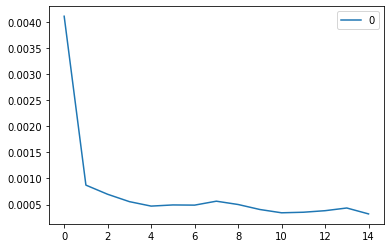

In [0]:
pd.DataFrame(ae_.loss_curve_).plot()

In [0]:
#printing the most outlier speeches:
def key_consine_similarity(tupple):
    return tupple[1]

def get_computed_similarities(vectors, predicted_vectors, reverse=False):
    data_size = len(df_m)
    cosine_similarities = []
    for i in range(data_size):
        cosine_sim_val = (1 - cosine(vectors[i], predicted_vectors[i]))
        cosine_similarities.append((i, cosine_sim_val))

    return sorted(cosine_similarities, key=key_consine_similarity, reverse=reverse)

def display_top_n(sorted_cosine_similarities, n=5):
    speech_date = []
    speech_person = []
    for i in range(n):
        index, consine_sim_val = sorted_cosine_similarities[i]
        print('Date of speech: ', df_m.iloc[index, 6],df_m.iloc[index, 0])
        speech_date.append((df_m.iloc[index, 6],df_m.iloc[index, 0]))
        print('Speech by: ', df_m.iloc[index, 2], df_m.iloc[index, 5])
        speech_person.append((df_m.iloc[index, 2],df_m.iloc[index, 5]))
        print('Cosine Sim Val :', consine_sim_val)
        print('---------------------------------')

    return(speech_date, speech_person)

In [0]:
print('Top 10 most unique speeches in Folketinget')
sorted_cosine_similarities = get_computed_similarities(vectors=doc2vec_vectors, predicted_vectors=predicted_vectors)
date, person = display_top_n(sorted_cosine_similarities=sorted_cosine_similarities, n=10)

Top 10 most unique speeches in Folketinget
Date of speech:  2012-05-15 21:55:40.190000
Speech by:  Christine Antorini S
Cosine Sim Val : -0.2745416535718954
---------------------------------
Date of speech:  2013-12-05 13:29:53.427000
Speech by:  Stine Brix EL
Cosine Sim Val : -0.2621228777603084
---------------------------------
Date of speech:  2010-02-05 12:31:53.037000
Speech by:  Christian H. Hansen UFG
Cosine Sim Val : -0.25793147251320425
---------------------------------
Date of speech:  2012-10-23 13:58:29.433000
Speech by:  Mai Henriksen nan
Cosine Sim Val : -0.23184202946833388
---------------------------------
Date of speech:  2011-12-20 15:54:51.270000
Speech by:  Anne Baastrup SF
Cosine Sim Val : -0.2243537877948656
---------------------------------
Date of speech:  2010-01-26 15:33:28.757000
Speech by:  Per Ørum Jørgensen KD
Cosine Sim Val : -0.21562379226167216
---------------------------------
Date of speech:  2010-11-18 13:56:07.410000
Speech by:  Peter Westermann SF


### Validating results

#### Distribution

In [0]:
sim = pd.DataFrame(sorted_cosine_similarities,columns = ['idx','Similarity'])

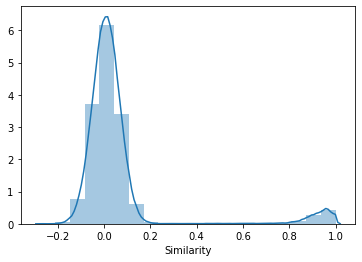

In [0]:
sns.distplot(sim['Similarity'],bins=20);#.savefig('/content/gdrive/My Drive/Uni/MMC/4. semester/CDA/plots/dist.png')

#### Speeches

In [0]:
# we have the following persons speaking
for i, date_ in enumerate(date):
  print(date_, person[i])

('2012-05-15', '21:55:40.190000') ('Christine Antorini', 'S')
('2013-12-05', '13:29:53.427000') ('Stine Brix', 'EL')
('2010-02-05', '12:31:53.037000') ('Christian H. Hansen', 'UFG')
('2012-10-23', '13:58:29.433000') ('Mai Henriksen', nan)
('2011-12-20', '15:54:51.270000') ('Anne Baastrup', 'SF')
('2010-01-26', '15:33:28.757000') ('Per Ørum Jørgensen', 'KD')
('2010-11-18', '13:56:07.410000') ('Peter Westermann', 'SF')
('2010-01-13', '18:04:47.190000') ('Bertel Haarder', 'V')
('2013-05-29', '20:07:55.140000') ('Thomas Danielsen', 'V')
('2013-10-03', '13:55:00.503000') ('Kristian Thulesen Dahl', 'S')


In [0]:
#which outlier speech to look at
top_x = 8

In [0]:
len(df_m[(df_m.Starttid == date[top_x-1][1]) & (df_m.Navn == person[top_x-1][0])].iloc[0,4])

1370

In [0]:
print(df_m[(df_m.Starttid == date[top_x-1][1]) & (df_m.Navn == person[top_x-1][0])].iloc[0,4])

Det er sådan, at antallet eller procentdelen af unge, som er under 40, og som har taget en ungdomsuddannelse, er faldet under højkonjunkturen. Jeg er overbevist om, at det er i gang med at stige nu. Det er også rigtigt, at hvis man kun tæller dem, der har en ungdomsuddannelse, er det gået lidt tilbage, og det ligger i øjeblikket omkring 80 pct. Det er fuldstændig rigtigt.Jeg er også helt sikker på, at da man fastsatte 85-procent-målsætningen for 2010, havde man ikke tænkt på, at der også var nogle, der tog en videregående uddannelse uden at have en ungdomsuddannelse. Derfor kan spørgeren jo have lidt ret i, at målsætningen ikke er nået, men så er det jo da en trøst, at der er så mange, som tager en videregående uddannelse uden at have en ungdomsuddannelse. Det tror jeg også spørgeren mener. Mit politiske mål er, at der er endnu flere end 5 pct., som får lov at gå den skæve vej til en videregående uddannelse.Sandheden er jo, at vores uddannelser er alt for stive. Optagelseskravene er al

From just looking at the top 10 different speeches, there is nothing in particular that stands out. 

#### Checking anormalies over time

In [0]:
#checking that we have observations for all speeches
len(sorted_cosine_similarities)

114013

In [0]:
type(sorted_cosine_similarities[0])

tuple

In [0]:
#making the list into a pandas, such that we can merge the similarity measure on to the dataframe
#similarities = pd.DataFrame(sorted_cosine_similarities)
#similarities.columns = [['index_','similarity']]
similarities = pd.DataFrame(sorted_cosine_similarities, columns =['place','score']) 

In [0]:
#df_m.head()

In [0]:
#making a column in df_m which can be merged
df_m['index'] = list(df_m.index)

In [0]:
similarities = similarities.sort_values(by= ['place'],  ascending= True)
#similarities.head()

In [0]:
print('Length of similarities', len(similarities), 'length of the speeches', len(df_m))

Length of similarities 114013 length of the speeches 114013


In [0]:
df_m.shape

(114013, 12)

In [0]:
df_m = df_m.merge(similarities, left_on= 'index', right_on = 'place')

In [0]:
df_m.shape

(114013, 14)

In [0]:
#df_m.to_csv('/content/drive/My Drive/Uni/MMC/4. semester/CDA/data/DPC_speeches_processed_w_similarities_300_200_100.csv')

## <font color='blue'>Part 6</font>: Results and anormalies
<a id=part6></a>

In [0]:
#reading the dataframe that keeps all the similarities
df = pd.read_csv('/content/gdrive/My Drive/Uni/MMC/4. semester/CDA/data/DPC_speeches_processed_w_similarities_300_200_100.csv') #DPC_speeches_processed_w_similarities.csv')
df = df.reset_index().iloc[:,2:]

In [0]:
#deleting the two columns which was used to merge the DF's
del df['index']
del df['place']

In [0]:
#looking at the df
df.head()

,Starttid,Sluttid,Navn,Rolle,Tekst,Parti,Dato,Tekst_clean,T_Tekst,T_Tekst_stopw,T_Tekst_stopw_stem,score
0,13:00:52.110000,13:05:42.060000,Karen J. Klint,medlem,Tak for det. Det er jo dejligt at se så fyldt ...,S,2011-09-30,tak for det det er jo dejligt at se så fyldt e...,"['tak', 'for', 'det', 'det', 'er', 'jo', 'dejl...","['dejligt', 'se', 'fyldt', 'sal', 'publikumsbæ...","['dej', 'se', 'fyld', 'sal', 'publikumsbænk', ...",0.053486
1,13:05:42.060000,13:06:52.970000,Karen J. Klint,medlem,Vedrørende valget i Grønland indstiller et eni...,S,2011-09-30,vedrørende valget i grønland indstiller et eni...,"['vedrørende', 'valget', 'i', 'grønland', 'ind...","['vedrørende', 'valget', 'grønland', 'indstill...","['vedrør', 'valg', 'grønland', 'indstil', 'eni...",0.006949
2,13:01:23.263000,13:03:10.263000,John Dyrby Paulsen,medlem,Tak for det. Jeg står her med en rapport fra F...,S,2011-03-02,tak for det jeg står her med en rapport fra fo...,"['tak', 'for', 'det', 'jeg', 'står', 'her', 'm...","['står', 'rapport', 'forsvarets', 'færdselssik...","['står', 'rapport', 'forsvar', 'færdselssikker...",-0.014555
3,13:03:11.407000,13:04:19.743000,Gitte Lillelund Bech,minister,Jeg takker for spørgsmålet. Hr. John Dyrby Pau...,V,2011-03-02,jeg takker for spørgsmålet hr john dyrby pauls...,"['jeg', 'takker', 'for', 'spørgsmålet', 'hr', ...","['takker', 'john', 'dyrby', 'paulsen', 'fuldst...","['tak', 'john', 'dyrby', 'pauls', 'fuldstænd',...",0.037837
4,13:04:20.913000,13:05:18.180000,John Dyrby Paulsen,medlem,Tak for svaret. Det er jeg jo enig med ministe...,S,2011-03-02,tak for svaret det er jeg jo enig med minister...,"['tak', 'for', 'svaret', 'det', 'er', 'jeg', '...","['svaret', 'enig', 'svært', 'uenig', 'underlig...","['svar', 'enig', 'svært', 'uen', 'under', 'rap...",-0.115678


In [0]:
df.iloc[0,-3]

"['dejligt', 'se', 'fyldt', 'sal', 'publikumsbænkene', 'højtidelig', 'dag', 'formand', 'udvalget', 'prøvelse', 'valgene', 'kan', 'oplyse', 'følgende', 'udvalgets', 'arbejde', 'idet', 'samtidig', 'henvise', 'offentliggjorte', 'betænkning', 'indstillingerne', 'arbejdet', 'sædvanlig', 'vedrørt', 'tre', 'første', 'vedrørt', 'gyldighed', 'valghandlingen', 'herunder', 'valgets', 'forberedelse', 'stemmeafgivelsen', 'optællingen', 'selve', 'stemmesedlerne', 'vurderingen', 'samt', 'valgbøgerne', 'disses', 'førelse', 'm', 'm', 'andet', 'vedrørt', 'godkendelse', 'ændringer', 'indenrigs', 'sundhedsministeriets', 'foretagne', 'opgørelser', 'beregninger', 'tredje', 'vedrørt', 'godkendelse', 'kandidater', 'opnået', 'valg', 'gyldigheden', 'valghandlingen', 'kan', 'sige', 'udvalget', 'gennemgået', 'indenrigs', 'sundhedsministeriets', 'redegørelse', 'indeholder', 'bemærkninger', 'gennemgangen', 'valgbogsudskrifterne', 'givet', 'ministeriet', 'anledning', 'hvert', 'valg', 'udfordringer', 'lige', 'overstå

### Looking at anormalies over time

Remember:
Two vectors with the same orientation have a cosine similarity of 1, two vectors oriented at 90° relative to each other have a similarity of 0, and two vectors diametrically opposed have a similarity of -1. 

This means, that outliers have very low score, and hence the lowest scores are the biggest outliers. What we are measuring the cosine similarity between, is the predicted vector, and the actual vector of a given speech. This should be a type of outlier prediction, since the Autoencoder has learned to re-create the output from the input. Hence, if the two vectors have a large angle between them, the cosine similarity will be negative. 

In [0]:
#making the dates into datetime
df['Dato'] = pd.to_datetime(df['Dato'])

In [0]:
#sorting out observations after 2015 (we are also only looking at 09-14)
df = df[df.Dato<'2015-01-01']

For this, we can also add which party has had most speaking time on the particular day, and which parties in general are the most 'anormal' speeches.

In [0]:
df.groupby(df.Dato.dt.year).mean()['score']

Dato
2009    0.061162
2010    0.059678
2011    0.062533
2012    0.061639
2013    0.060343
2014    0.058327
Name: score, dtype: float64

In [0]:
df.groupby(df.Dato.dt.year).std()['score']/10

Dato
2009    0.021756
2010    0.021470
2011    0.021843
2012    0.021867
2013    0.021629
2014    0.021439
Name: score, dtype: float64

In [0]:
#function for plotting with std
def plot_time(df, time, save= 'no', std_ = 'no'):
  div = 1
  std = 0
  #data
  if time == 'year':
    x = df.groupby(df.Dato.dt.year).mean()['score'].reset_index().iloc[:,0].to_list()
    y = df.groupby(df.Dato.dt.year).mean()['score'].reset_index().iloc[:,1].to_list()
    if std_ == 'yes':
      std = df.groupby(df.Dato.dt.year).std()['score']/div
      std = std.reset_index().iloc[:,1].to_list() #std of the time interval

  elif time == 'week':
    x = df.groupby(df.Dato.dt.week).mean()['score'].reset_index().iloc[:,0].to_list()
    y = df.groupby(df.Dato.dt.week).mean()['score'].reset_index().iloc[:,1].to_list()
    if std_ == 'yes':
      std = df.groupby(df.Dato.dt.week).std()['score']/div
      std = std.reset_index().iloc[:,1].to_list() #std of the time interval
    
  elif time == 'date':
    x = df.groupby(df.Dato.dt.date).mean()['score'].reset_index().iloc[:,0].to_list()
    y = df.groupby(df.Dato.dt.date).mean()['score'].reset_index().iloc[:,1].to_list()
    #std = df.groupby(df.Dato.dt.date).std()['score']/div
    #std = std.reset_index().iloc[:,1].to_list() #std of the time interval
    std = 0

  # error bar values w/ different -/+ errors
  lower_error = std
  upper_error = std
  asymmetric_error = [lower_error, upper_error]

  #ax0 = plt.plot()
  #ax0.errorbar(x, y, yerr=std, fmt='-o')
  #ax0.set_title('Title')

  #x = np.array([1, 2, 3, 4, 5])
  #y = np.power(x, 2) # Effectively y = x**2
  e = std

  plt.errorbar(x, y, e)#, linestyle='None', marker='^')
  plt.xlabel(time)
  plt.ylabel('Cosine similarity')
  plt.title('Periodic development of behavior in speeches.')

  plt.grid(True)

  if save == 'yes':
    plt.savefig('/content/gdrive/My Drive/Uni/MMC/4. semester/CDA/plots/'+time+'.png')

  plt.show()

  #ax1.errorbar(x, y, xerr=asymmetric_error, fmt='o')
  #ax1.set_title('variable, asymmetric error')
  #ax1.set_yscale('log')
  #plt.show()

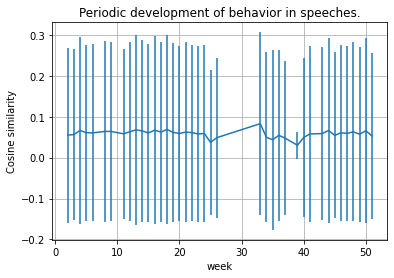

In [0]:
plot_time(df, 'week', 'no', 'yes')

##### Years

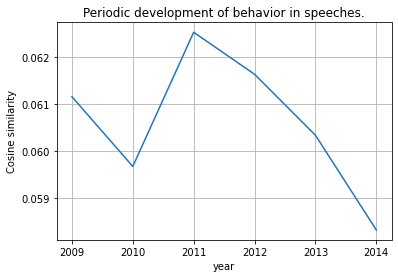

In [0]:
#plotting over the years
plot_time(df, 'year', 'yes')

We had a Folketingsvalg in 2011 and 2015, which might be why the two years up to that particular event might be low in similarity. 

##### Weeks

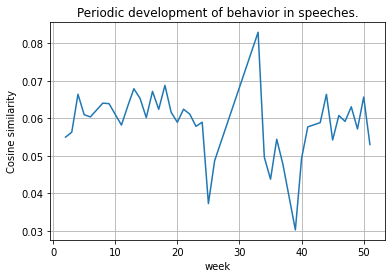

In [0]:
#plotting over weeks
plot_time(df, 'week', 'yes')
#df.groupby(df.Dato.dt.week).mean()['score'].plot()

+- std?

In [0]:
#saving weeks
w = df.groupby(df.Dato.dt.week).mean()['score'].reset_index()

In [0]:
#sorting
w.sort_values(by=['score']).head()

,Dato,score
28,39,0.030217
21,25,0.037247
25,35,0.043754
27,37,0.047697
22,26,0.048677


Week 25	June 15, 2009	June 21, 2009

Week 35	Aug. 24, 2009	Aug. 30, 2009

Week 37	Sep. 7, 2009	Sep. 13, 2009

Week 39	Sep. 21, 2009	Sep. 27, 2009

Week 40	Sep. 28, 2009	Oct. 4, 2009

Folketinget has holdiday from mid-June and opens first Tuesday in October: https://da.wikipedia.org/wiki/Folketings%C3%A5r

Forslag til næste års finanslov fremsættes inden udgangen af august (følge af § 45). Folketinget samles i september – uanset sommerferien – til førstebehandling af lovforslaget. Finanslovsforslaget bortfalder herefter ved folketingsårets slutning, men genfremsættes efter det nye folketingsårs begyndelse den første tirsdag i oktober. Lovforslaget gennemgår herefter som andre lovforslag tre behandlinger i Folketinget. Tredjebehandlingen finder normalt sted i december. : https://da.wikipedia.org/wiki/Finansloven

##### Days

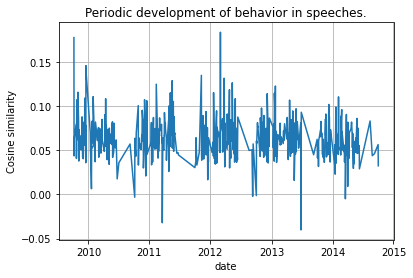

In [0]:
#plotting over the days
plot_time(df, 'date', 'yes')
#df.groupby(df.Dato.dt.date).mean()['score'].plot()

In [0]:
#saving the mean scores of any given day:
date_scores = df.groupby(df.Dato.dt.date).mean()['score'].reset_index().sort_values(by=['score'])

In [0]:
#looking at the 5 highest scores
date_scores.head()

,Dato,score
418,2013-06-26,-0.040278
175,2011-03-19,-0.032150
485,2014-03-19,-0.005050
109,2010-10-05,-0.003316
312,2012-09-10,-0.002289


2012 1. oktober – Den nye lukkelov træder i kraft, og butikker kan nu som hovedregel holde åbent alle ugens dage året rundt.



### Looking at anormalities over speeches, parties, and roles

##### Single speeches

We can look at the head and tail of the sorted scores, to see which are the 'most normal' and which are the most outliers.

In [0]:
#looking at the head
df.sort_values(by=['score']).head()

,Starttid,Sluttid,Navn,Rolle,Tekst,Parti,Dato,Tekst_clean,T_Tekst,T_Tekst_stopw,T_Tekst_stopw_stem,score
42940,21:55:40.190000,21:56:28.440000,Christine Antorini,minister,"Jeg tror, at Enhedslistens ordfører godt ved, ...",S,2012-05-15,jeg tror at enhedslistens ordfører godt ved at...,"['jeg', 'tror', 'at', 'enhedslistens', 'ordfør...","['tror', 'enhedslistens', 'godt', 'ved', 'lidt...","['tror', 'enhedslist', 'godt', 'ved', 'lidt', ...",-0.274542
72047,13:29:53.427000,13:30:04.207000,Stine Brix,medlem,Undringen må blafre i vinden. Jeg må bede hr. ...,EL,2013-12-05,undringen må blafre i vinden jeg må bede hr ch...,"['undringen', 'må', 'blafre', 'i', 'vinden', '...","['undringen', 'må', 'blafre', 'vinden', 'må', ...","['undring', 'må', 'blafr', 'vind', 'må', 'bed'...",-0.262123
92575,12:31:53.037000,12:32:27.617000,Christian H. Hansen,medlem,"Jamen jeg har jo ikke stået her og påstået, at...",UFG,2010-02-05,jamen jeg har jo ikke stået her og påstået at ...,"['jamen', 'jeg', 'har', 'jo', 'ikke', 'stået',...","['jamen', 'stået', 'påstået', 'hele', 'verdens...","['jam', 'stået', 'påstå', 'hel', 'verdensopfat...",-0.257931
46384,13:58:29.433000,13:59:03.543000,Mai Henriksen,medlem,"»Bland jer uden om, hvem vi ansætter. Det er b...",NaN,2012-10-23,»bland jer uden om hvem vi ansætter det er bes...,"['»', 'bland', 'jer', 'uden', 'om', 'hvem', 'v...","['»', 'bland', 'uden', 'hvem', 'ansætter', 'be...","['bland', 'uden', 'hvem', 'ansæt', 'besked', '...",-0.231842
29857,15:54:51.270000,15:55:29.177000,Anne Baastrup,medlem,Jeg ved det ikke helt. Var det ikke de oplysni...,SF,2011-12-20,jeg ved det ikke helt var det ikke de oplysnin...,"['jeg', 'ved', 'det', 'ikke', 'helt', 'var', '...","['ved', 'helt', 'oplysninger', 'karsten', 'lau...","['ved', 'helt', 'oplysning', 'karst', 'lauritz...",-0.224354


In [0]:
#looking at the tail
df.sort_values(by=['score']).tail()

,Starttid,Sluttid,Navn,Rolle,Tekst,Parti,Dato,Tekst_clean,T_Tekst,T_Tekst_stopw,T_Tekst_stopw_stem,score
76493,10:35:21.003000,10:36:00.923000,Jonas Dahl,medlem,"Jeg er gladere for at benytte ordet bane, men ...",SF,2013-10-31,jeg er gladere for at benytte ordet bane men d...,"['jeg', 'er', 'gladere', 'for', 'at', 'benytte...","['gladere', 'benytte', 'ordet', 'bane', 'kan',...","['glad', 'benyt', 'ord', 'ban', 'forskel', 'fo...",0.999485
73633,10:10:45.910000,10:16:45.123000,Hans Christian Schmidt,medlem,"Tak for det, formand. Når vi i dag om et øjebl...",V,2014-04-10,tak for det formand når vi i dag om et øjeblik...,"['tak', 'for', 'det', 'formand', 'når', 'vi', ...","['formand', 'dag', 'øjeblik', 'vedtager', 'l',...","['formand', 'dag', 'øjeblik', 'vedtag', 'l', '...",0.999485
103528,15:31:33.327000,15:32:09.377000,Carina Christensen,minister,Jamen det er jeg sådan set enig i. Jeg sagde j...,KF,2009-10-21,jamen det er jeg sådan set enig i jeg sagde jo...,"['jamen', 'det', 'er', 'jeg', 'sådan', 'set', ...","['jamen', 'set', 'enig', 'sagde', 'gjort', 'go...","['jam', 'set', 'enig', 'sagd', 'gjort', 'god',...",0.999486
39200,15:18:17.873000,15:19:13.343000,Karen Hækkerup,minister,"Tak. Jeg vil gerne starte med at sige, at jeg ...",S,2011-12-07,tak jeg vil gerne starte med at sige at jeg er...,"['tak', 'jeg', 'vil', 'gerne', 'starte', 'med'...","['gerne', 'starte', 'sige', 'helt', 'sikker', ...","['gern', 'start', 'helt', 'sik', 'ansat', 'sta...",0.999486
3080,15:08:34.887000,15:12:08.153000,Claus Hjort Frederiksen,minister,Regeringen har på den baggrund fokus på bedre ...,V,2011-05-25,regeringen har på den baggrund fokus på bedre ...,"['regeringen', 'har', 'på', 'den', 'baggrund',...","['regeringen', 'baggrund', 'fokus', 'bedre', '...","['regering', 'baggrund', 'fokus', 'bedr', 'øko...",0.999486


##### By parties

In [0]:
df.groupby('Parti').mean()['score']

Parti
ALT              0.070677
DF               0.056047
EL               0.054608
IA               0.112865
JF               0.086253
KD               0.069272
KF               0.071483
LA               0.054571
RV               0.061747
S                0.061766
SF               0.062297
SIU              0.082107
SP               0.089222
T                0.082969
UFG              0.066523
V                0.060332
udpeget af SF    0.097290
Name: score, dtype: float64

##### By person

In [0]:
df.groupby(['Navn','Parti']).mean()['score'].reset_index().sort_values(by=['score']).head()

,Navn,Parti,score
9,Anne-Marie Meldgaard,S,-0.003625
184,Niels Sindal,S,0.009381
71,Hüseyin Arac,S,0.011510
133,Laura Lindahl,LA,0.012212
36,Daniel Rugholm,KF,0.012461


##### By function

In [0]:
df.groupby(['Rolle','Parti']).mean()['score']

Rolle            Parti        
aldersformanden  RV              -0.011220
                 V                0.004742
medlem           ALT              0.051637
                 DF               0.056047
                 EL               0.054608
                 IA               0.112865
                 JF               0.086253
                 KD               0.069272
                 KF               0.062875
                 LA               0.054571
                 RV               0.052511
                 S                0.058689
                 SF               0.061106
                 SIU              0.082107
                 SP               0.089222
                 T                0.082969
                 UFG              0.066523
                 V                0.056527
                 udpeget af SF    0.097290
minister         ALT              0.082028
                 KF               0.087685
                 RV               0.087903
                 S     

It actually seems like, that there is a trend in parties being more 'normal' when being in office (holding minister positions), than when being in the opposition. This, again, just forces the fact that it could be fun to add sentiment as an input to the NN. 

### Anormaly-distribution

In [0]:
#saving the sorted values
dist = df.sort_values(by=['score']).score.reset_index()

In [0]:
dist.head()

,index,score
0,67634,-0.379502
1,30902,-0.367491
2,13328,-0.346520
3,14706,-0.327124
4,68844,-0.322206


In [0]:
#deleting the index-columns
del dist['index']

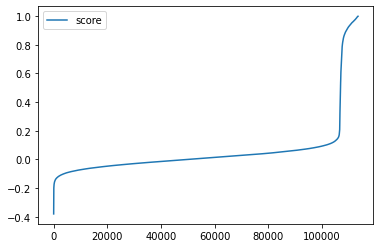

In [0]:
dist.plot()

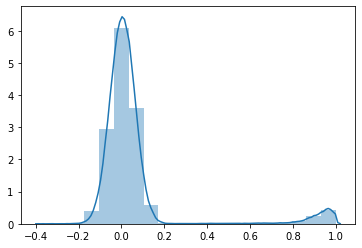

In [0]:
sns.distplot(dist,bins=20);

NB: from looking at the distribution, we are seeing that something is a bit wired, since most of them are distributed around 0. A cosine 0 means that the predicted vector (of the speech) and the actual vector has a 90 degree angle, which essentially means that there is no similarity. 

There might be several reasons for this. The most obvious one (and most likely the root course) is due to the Doc2Vec is not made given a Danish framework. This means, that it utilizes English word-embeddings, does not hold the latent meaning of the Danish words. 

NEXT: Google: doc2vec danish

## <font color='blue'>Part 7</font>: Decreasing vecor sizes
<a id=part7></a>

In [0]:
def decrease_comp(dec2vec_, predicted_, comp, bins_, std):
    #if std == 'yes':
      #Standardizing
    #  doc2vec_ = StandardScaler().fit_transform(dec2vec_)
    #  predicted_ = StandardScaler().fit_transform(predicted_)

    #defining pca and turning into vectors
    pca = PCA(n_components=comp)

    #transforming the standardized doc2vec into its 50 principal components
    doc2vec_comp = pca.fit_transform(doc2vec_)
    predicted_comp = pca.fit_transform(predicted_)

    #calculating similarity and plotting
    sorted_cosine_similarities = get_computed_similarities(vectors= doc2vec_comp, predicted_vectors= predicted_comp)
    sim = pd.DataFrame(sorted_cosine_similarities,columns = ['idx','sim'])
    sns.distplot(sim['sim'],bins=bins_);

In [0]:
decrease_comp(doc2vec_vectors, predicted_vectors, 300, 20, 'no') #50, 20 worked very well

NameError: ignored

In [0]:
#standardizing the vectors vectors=doc2vec_vectors, predicted_vectors=predicted_vectors

##doc2vec
doc2vec_vectors_s = StandardScaler().fit_transform(doc2vec_vectors)

##predicted
predicted_vectors_s = StandardScaler().fit_transform(predicted_vectors)

In [0]:
#defining the pca w. 50 components
pca = PCA(n_components=50)

#transforming the standardized doc2vec into its 50 principal components
doc2vec_vectors_comp = pca.fit_transform(doc2vec_vectors_s)

#transforming the standardized predicted vectors into its 50 principal components

array([[-4.98320550e-01, -5.82904756e-01,  4.06956859e-02, ...,
        -7.07131403e-04, -1.07771587e-02, -3.31347063e-03],
       [-5.05706429e-01, -5.83132923e-01,  3.28796543e-02, ...,
         1.07227266e-02,  1.16919456e-02,  7.22786551e-03],
       [-5.06644666e-01, -5.81250072e-01,  2.66945176e-02, ...,
        -1.15194800e-03, -1.19047454e-02,  1.02384307e-03],
       ...,
       [-4.86760587e-01, -5.90692401e-01,  2.56802719e-02, ...,
         1.86244566e-02,  1.07103493e-04, -1.41794365e-02],
       [-4.87635881e-01, -5.79493940e-01,  3.63905393e-02, ...,
         1.77857820e-02,  8.10466427e-03, -8.45501944e-03],
       [-4.95359600e-01, -5.76493323e-01,  3.54273431e-02, ...,
        -2.11870996e-03,  5.80639718e-03,  1.00123975e-02]], dtype=float32)

#### plotting in 2 dimensions

In [0]:
#pca on doc2vec
pca_2 = PCA(n_components=2)
#transforming the standardized doc2vec into its 50 principal components
doc2vec_vectors_comp_2 = pca_2.fit_transform(doc2vec_vectors_s)

In [0]:
comp_2 = pd.DataFrame(data = doc2vec_vectors_comp_2, columns = ['p1', 'p2'])

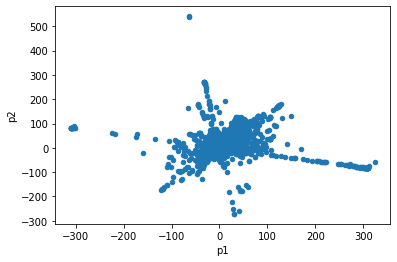

In [0]:
comp_2.plot(kind='scatter', x='p1',y='p2')

In [0]:
#pca on predicted values
pca_2 = PCA(n_components=2)
#transforming the standardized doc2vec into its 50 principal components
predicted_vectors_comp_2 = pca_2.fit_transform(predicted_vectors_s)

In [0]:
print(predicted_vectors_comp_2.shape,doc2vec_vectors_comp_2.shape)

(114013, 2) (114013, 2)


In [0]:
#looking at the biggest outliers from only 2 components
print('Top 10 most unique speeches in Folketinget')
sorted_cosine_similarities = get_computed_similarities(vectors=doc2vec_vectors_comp_2, predicted_vectors=predicted_vectors_comp_2)
date, person = display_top_n(sorted_cosine_similarities=sorted_cosine_similarities, n=10)

Top 10 most unique speeches in Folketinget
Date of speech:  2013-11-26 14:13:24.773000
Speech by:  Jørgen Arbo-Bæhr EL
Cosine Sim Val : -0.9999936778863288
---------------------------------
Date of speech:  2014-03-25 16:08:57.813000
Speech by:  Kristian Pihl Lorentzen V
Cosine Sim Val : -0.9999890372181883
---------------------------------
Date of speech:  2013-01-11 13:58:05.227000
Speech by:  Carsten Hansen S
Cosine Sim Val : -0.999971451569114
---------------------------------
Date of speech:  2012-10-10 15:37:52.210000
Speech by:  Inger Støjberg V
Cosine Sim Val : -0.9999456354821026
---------------------------------
Date of speech:  2010-02-03 20:02:35.607000
Speech by:  Lykke Friis V
Cosine Sim Val : -0.9999304530092505
---------------------------------
Date of speech:  2014-06-02 12:21:21.390000
Speech by:  Christian Juhl EL
Cosine Sim Val : -0.9999091816008487
---------------------------------
Date of speech:  2010-04-22 17:26:34.667000
Speech by:  Per Clausen EL
Cosine Sim Va

In [0]:
sim = pd.DataFrame(sorted_cosine_similarities,columns = ['idx','sim'])

In [0]:
sim.head()

,idx,sim
0,78853,-0.999994
1,75247,-0.999989
2,60607,-0.999971
3,59129,-0.999946
4,109978,-0.999930


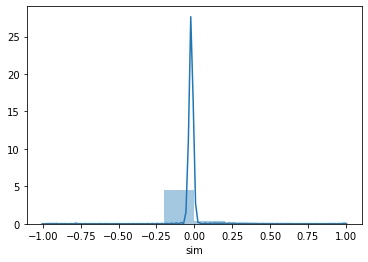

In [0]:
sns.distplot(sim['sim'],bins=10);

## Word2Vec and average

In [0]:
def get_model():
    from gensim.models.wrappers.fasttext import FastText
    return FastText.load_fasttext_format('/content/drive/My Drive/Uni/MMC/3. semester/NLP/problem/Practical/wiki/wiki.da.bin')

#Create word-vectors: (This model is used in the )
def word2vec(word):
    empty_list = np.ones((300))
    wordemb = []
    try: # If not empty
        word_emb = lan_model.wv.word_vec(word)
        wordemb.append(word_emb)
    except: # If empty or word not known create list of ones:
        wordemb.append(empty_list)
    return wordemb

In [0]:
transfer_words = True

In [0]:
#resetting the index om df_m 
#df_m = df_m.reset_index().iloc[:,1:]
df_m = pd.read_csv('/content/drive/My Drive/Uni/MMC/4. semester/CDA/data/DPC_speeches_processed.csv')
df_m = df_m.reset_index().iloc[:,2:]

FileNotFoundError: ignored

In [0]:
df_m.head()

NameError: ignored

In [0]:
import ast
df_m['T_Tekst_stopw_stem'] = df_m['T_Tekst_stopw_stem'].apply(lambda x: ast.literal_eval(x))

NameError: ignored

In [0]:
df_m.shape

(114013, 11)

In [0]:
cut = int(np.round(df_m.shape[0]/2))
df_m_sub = df_m.iloc[:cut,:]
df_m_sub.shape

(57006, 11)

In [0]:
if transfer_words == True:
    train_x = df_m_sub 
    
    lan_model = get_model()
    
    #train_x_l = []
    #for i in range(len(train_x)):
    #    train_x_l.append([[w.lower() for w in line] for line in train_x[i]])

    train_x_l_em = []
    for i in range(len(train_x)):
        train_x_l_em.append([[word2vec(w) for w in line] for line in train_x.iloc[i,-1]])
        if i%1000==0:
          print(i)
        
    x_train = train_x_l_em

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000


In [0]:
#x_train[0]#[1][0])

In [0]:
#x_train[document][word][0][0].shape
x_train[2][1][0][0].shape

In [0]:
with open('/content/drive/My Drive/Uni/MMC/4. semester/CDA/data/word2vec.pkl', 'wb') as f:
    pickle.dump(x_train, f)